In [3]:
pip install torch numpy pandas scikit-learn tensorflow shap scikit-optimize openpyxl 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)


In [4]:
!pip install pandas numpy matplotlib scikit-learn scipy tensorflow boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from BTC_helper import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap

In [9]:
binance_file_merged="/content/Binance_data_combined_v2_merged.xlsx"
coinbase_file_merged="/content/Coinbase_data_combined_v2_merged.xlsx"
kraken_file_merged="/content/Kraken_data_combined_v2_merged.xlsx"

# Load merged data from excel files into DataFrames
kraken_data = pd.read_excel(kraken_file_merged, index_col=[0, 1])
coinbase_data = pd.read_excel(coinbase_file_merged, index_col=[0, 1])
binance_data = pd.read_excel(binance_file_merged, index_col=[0, 1])
#print("Binance Data\n",binance_data.tail(3))
#print("Kraken Data\n",kraken_data.tail(3))
#print("Coinbase Data\n",coinbase_data.tail(3))

# One-hot encode the Coin column to create separate columns for each coin
kraken_data_encoded = pd.get_dummies(kraken_data.reset_index(level='Coin'), columns=['Coin']).sort_index()
# Get a list of the current column names
cols = list(kraken_data_encoded.columns)
# Move the 'bid_ask_spread' column to the end
cols.remove('bid_ask_spread')
cols.append('bid_ask_spread')
# Reindex the DataFrame with the new column order
kraken_data_encoded = kraken_data_encoded.reindex(columns=cols)
kraken_data_encoded

,open,high,low,close,volume,github_commits,google_trends,tweets,VWAP,OBV,...,WilliamsR,Maker Fee,Transaction Fee,AML_KYC_required,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP,bid_ask_spread
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,963.658020,1003.080017,958.698975,998.325012,1.477750e+08,3,11,26461,986.701335,1.477750e+08,...,-85.607702,1,0.001,1,1,0,0,0,0,0.045246
2017-01-02,0.006523,0.006702,0.006334,0.006368,4.189780e+05,2,11,10854,0.006468,4.189780e+05,...,-0.972202,1,0.001,1,0,0,0,0,1,0.056397
2017-01-02,7.982310,8.471230,7.982310,8.172570,1.473170e+07,1,11,1751,8.208703,1.473170e+07,...,-57.418146,1,0.001,1,0,0,1,0,0,0.059430
2017-01-02,11.207800,11.491800,10.956100,11.229200,3.684210e+06,3,11,1,11.225700,3.684210e+06,...,-80.095461,1,0.001,1,0,1,0,0,0,0.047728
2017-01-02,4.329120,4.521530,4.328710,4.511590,1.133750e+07,3,11,220,4.453943,1.133750e+07,...,-78.462315,1,0.001,1,0,0,0,1,0,0.043574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,1821.704354,1840.173109,1811.118477,1813.860559,5.556444e+09,4,22,21382,1651.012175,1.291504e+12,...,-24.500885,1,0.001,1,0,0,1,0,0,0.015915
2023-04-02,89.686441,93.853620,89.552831,92.875351,5.487623e+08,1,22,821,120.712387,2.531721e+11,...,-15.991743,1,0.001,1,0,0,0,1,0,0.046899
2023-04-02,58.448642,59.978189,58.309868,58.538757,7.818441e+07,10,22,417,165.258971,5.067623e+10,...,-58.300839,1,0.001,1,0,1,0,0,0,0.028208


In [10]:
print(kraken_data_encoded.shape)
num_missing=kraken_data_encoded.isnull().sum()
print(num_missing[num_missing >0])
kraken_data_encoded.tail(1)

(11455, 26)
Series([], dtype: int64)


,open,high,low,close,volume,github_commits,google_trends,tweets,VWAP,OBV,...,WilliamsR,Maker Fee,Transaction Fee,AML_KYC_required,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP,bid_ask_spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-02,0.538472,0.538472,0.501539,0.514741,1.829835e+09,1,22,12532,0.693678,2.397533e+11,...,-31.816643,1,0.001,1,0,0,0,0,1,0.071025


In [14]:
#High Correlation Treatment
corr_features = correlation(kraken_data_encoded, 0.95)
print('correlated features: ', len(set(corr_features)) )
print(corr_features)
df_reduced_corr= kraken_data_encoded.drop(columns=['high', 'MACD_signal', 'close', 'low'])
print(df_reduced_corr.shape)
df_reduced_corr.columns
df_reduced_corr.head(2)

correlated features:  4
{'high', 'MACD_signal', 'close', 'low'}
(11455, 22)


,open,volume,github_commits,google_trends,tweets,VWAP,OBV,MFI,ADX,MACD,...,WilliamsR,Maker Fee,Transaction Fee,AML_KYC_required,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP,bid_ask_spread
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,963.658020,147775008.0,3,11,26461,986.701335,147775008.0,43.189602,0.0,-11.799248,...,-85.607702,1,0.001,1,1,0,0,0,0,0.045246
2017-01-02,0.006523,418978.0,2,11,10854,0.006468,418978.0,63.512876,0.0,0.000061,...,-0.972202,1,0.001,1,0,0,0,0,1,0.056397


In [19]:
##########################OUTLIER TREATMENT ####################################
from scipy.signal import savgol_filter
# Apply Hampel filter to detect outliers and impute with rolling median
data=df_reduced_corr.copy()
#data=data.reset_index(inplace=False)
#data.drop(['Date'], axis='columns', inplace=True)
col_names_reduced = [column for column in df_reduced_corr]

df_outliers_removed= hampel_filter_data(data, col_names_reduced,15,True)


In [27]:
# Apply Savgol filter to reduce noise in the timeseries
# col_names_reduced = [column for column in df_reduced_corr]
df_reduced_corr_smooth =df_outliers_removed.copy()
df_reduced_corr_smooth= savgol_filter_data(df_reduced_corr_smooth,col_names_reduced,window_size=15, polynomial_degree=3)
df_reduced_corr= df_reduced_corr_smooth.copy()
#df_reduced_corr.shape
# Convert the specified columns to integer values
cols_to_convert = ['AML_KYC_required','Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP']
df_reduced_corr[cols_to_convert] = df_reduced_corr[cols_to_convert].astype(int)
print(df_reduced_corr.shape)
df_reduced_corr

(11455, 22)


,open,volume,github_commits,google_trends,tweets,VWAP,OBV,MFI,ADX,MACD,...,WilliamsR,Maker Fee,Transaction Fee,AML_KYC_required,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP,bid_ask_spread
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,7.612183,9.979481e+06,2.669683,11.000000,3068.195475,7.747147,1.064935e+07,48.909765,0.000000,0.099642,...,-81.712784,1.0,0.001,1,0,0,0,0,0,0.048658
2017-01-02,7.274833,9.117652e+06,2.529412,11.000000,3422.555656,7.402037,9.466384e+06,50.618210,0.000000,0.153000,...,-79.437271,1.0,0.001,1,0,0,0,0,0,0.046810
2017-01-02,6.399332,9.405113e+06,2.504977,11.000000,3587.895023,6.504862,1.050922e+07,51.146121,0.000000,0.119954,...,-77.380255,1.0,0.001,1,0,0,0,0,0,0.045037
2017-01-02,6.056784,8.808749e+06,2.396380,11.000000,3373.505882,6.149371,1.074227e+07,53.346350,0.000000,0.174595,...,-75.428650,1.0,0.001,1,0,0,0,0,0,0.047095
2017-01-02,5.986184,7.052373e+06,2.342081,11.000000,3050.050679,6.050310,7.886001e+06,54.183039,0.000000,0.180864,...,-76.335539,1.0,0.001,1,0,0,0,0,0,0.036158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02,76.173804,3.941022e+09,4.241629,16.653394,10277.491855,148.403616,2.028938e+11,59.351904,25.984406,0.542714,...,-31.634932,1.0,0.001,1,0,0,0,0,0,0.031325
2023-04-02,76.785919,3.948066e+09,4.087783,17.933032,9954.205882,146.573292,2.064125e+11,58.831658,26.185720,0.580669,...,-32.809737,1.0,0.001,1,0,0,0,0,0,0.035914
2023-04-02,65.131837,4.019311e+09,3.698643,21.131222,10807.921719,125.161495,2.117411e+11,59.708298,30.188163,0.507407,...,-32.235032,1.0,0.001,1,0,0,0,0,0,0.041514


In [28]:
# Load and preprocess your data (assuming kraken_data_encoded is already preprocessed)
X = df_reduced_corr.drop('bid_ask_spread', axis=1)
y = df_reduced_corr['bid_ask_spread']

In [32]:

# Load and preprocess your data (assuming kraken_data_encoded is already preprocessed)
#X = kraken_data_encoded.drop('bid_ask_spread', axis=1)
#y = kraken_data_encoded['bid_ask_spread']

# Split the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Then split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and validation data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(6873, 1, 21)
(2291, 1, 21)
(2291, 1, 21)


In [33]:
df_reduced_corr.columns

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'Coin_BTC',
       'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP', 'bid_ask_spread'],
      dtype='object')

Epoch: 1/100, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 2/100, Training Loss: 0.0010, Validation Loss: 0.0020
Epoch: 3/100, Training Loss: 0.0009, Validation Loss: 0.0027
Epoch: 4/100, Training Loss: 0.0008, Validation Loss: 0.0026
Epoch: 5/100, Training Loss: 0.0008, Validation Loss: 0.0027


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/100, Training Loss: 0.0022, Validation Loss: 0.0021
Epoch: 2/100, Training Loss: 0.0011, Validation Loss: 0.0021
Epoch: 3/100, Training Loss: 0.0011, Validation Loss: 0.0026
Epoch: 4/100, Training Loss: 0.0011, Validation Loss: 0.0024
Epoch: 5/100, Training Loss: 0.0010, Validation Loss: 0.0025
Epoch: 1/100, Training Loss: 0.0011, Validation Loss: 0.0019
Epoch: 2/100, Training Loss: 0.0009, Validation Loss: 0.0022
Epoch: 3/100, Training Loss: 0.0009, Validation Loss: 0.0022
Epoch: 4/100, Training Loss: 0.0008, Validation Loss: 0.0015
Epoch: 5/100, Training Loss: 0.0008, Validation Loss: 0.0017
Epoch: 6/100, Training Loss: 0.0008, Validation Loss: 0.0016
Epoch: 7/100, Training Loss: 0.0007, Validation Loss: 0.0017
Epoch: 8/100, Training Loss: 0.0007, Validation Loss: 0.0016
Epoch: 1/100, Training Loss: 0.0013, Validation Loss: 0.0016
Epoch: 2/100, Training Loss: 0.0010, Validation Loss: 0.0024
Epoch: 3/100, Training Loss: 0.0010, Validation Loss: 0.0015
Epoch: 4/100, Training L

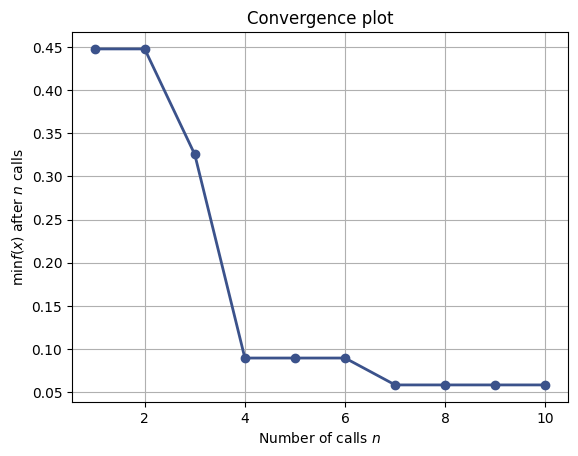

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap
from functools import partial
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args


# Custom Dataset class to work with PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Your data preprocessing code remains the same

# Create custom PyTorch model
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, lstm_units, dense_units, dropout_rate):
        super(CNNBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, conv_filters, kernel_size=input_size, padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm = nn.LSTM(conv_filters, lstm_units, bidirectional=True, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2*lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # Transpose the dimensions to make the output compatible with LSTM
        x, _ = self.bilstm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# Your hyperparameter search code remains the same

def train_evaluate_model(params):
    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = params[3]
    dropout_rate = params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    epochs = 100
    patience = 4
    min_val_loss = np.inf
    counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    return val_loss


# Define the search space for hyperparameters
search_space = [Integer(32, 128, name='conv_filters'),
                Integer(32, 128, name='lstm_units'),
                Integer(16, 64, name='dense_units'),
                Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
                Real(0.1, 0.5, name='dropout_rate'),
                Integer(8, 64, name='batch_size'),
                Categorical(['adam', 'adamax', 'rmsprop'], name='optimizer'),
                Categorical(['relu', 'linear'], name='activation')]

# Run Bayesian optimization
from skopt.plots import plot_convergence

# Run Bayesian optimization
result = gp_minimize(train_evaluate_model,
                     search_space,
                     n_calls=10,
                     random_state=42)

# Plot the convergence curve
plot_convergence(result)

# Print the best hyperparameters
best_params = result.x
print(f'Best hyperparameters: {best_params}')


In [37]:
print("Best hyperparameters returned by Bayesian Optimization:",best_params)

Best hyperparameters returned by Bayesian Optimization: [86, 35, 56, 0.00079342935945906, 0.25806009440072586, 60, 'adamax', 'linear']


Epoch: 1/1000, Training Loss: 0.0045, Test Loss: 0.0058
Epoch: 2/1000, Training Loss: 0.0017, Test Loss: 0.0069
Epoch: 3/1000, Training Loss: 0.0014, Test Loss: 0.0074
Epoch: 4/1000, Training Loss: 0.0013, Test Loss: 0.0067
Epoch: 5/1000, Training Loss: 0.0013, Test Loss: 0.0070
Epoch: 6/1000, Training Loss: 0.0012, Test Loss: 0.0074
Epoch: 7/1000, Training Loss: 0.0011, Test Loss: 0.0058
Epoch: 8/1000, Training Loss: 0.0011, Test Loss: 0.0063
Epoch: 9/1000, Training Loss: 0.0010, Test Loss: 0.0057
Epoch: 10/1000, Training Loss: 0.0009, Test Loss: 0.0054
Epoch: 11/1000, Training Loss: 0.0009, Test Loss: 0.0056
Epoch: 12/1000, Training Loss: 0.0009, Test Loss: 0.0052
Epoch: 13/1000, Training Loss: 0.0009, Test Loss: 0.0049
Epoch: 14/1000, Training Loss: 0.0008, Test Loss: 0.0046
Epoch: 15/1000, Training Loss: 0.0008, Test Loss: 0.0049
Epoch: 16/1000, Training Loss: 0.0008, Test Loss: 0.0040
Epoch: 17/1000, Training Loss: 0.0008, Test Loss: 0.0036
Epoch: 18/1000, Training Loss: 0.0008, T

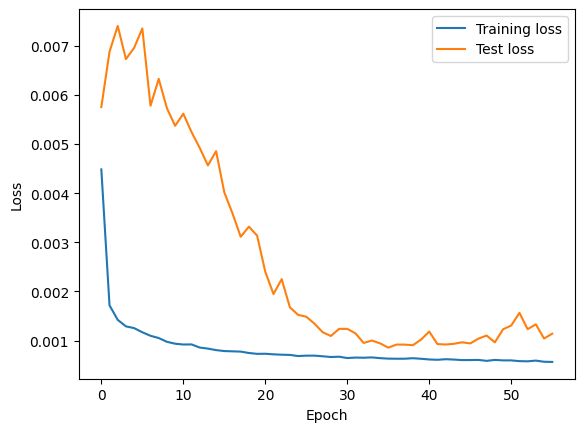

In [38]:

# Train the final model on the full dataset
best_params = result.x
conv_filters = best_params[0]
lstm_units = best_params[1]
dense_units = best_params[2]
learning_rate = best_params[3]
dropout_rate = best_params[4]
#batch_size = best_params[5]
batch_size = int(best_params[5])  # Convert batch_size to an integer


final_model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the final model on the full dataset
epochs = 1000
patience = 20
min_test_loss = np.inf
counter = 0

train_losses = []
test_losses = []
for epoch in range(epochs):
    final_model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    final_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = final_model(batch_X)
            outputs = torch.squeeze(outputs)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    # Print progress and loss values
    print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    if test_loss < min_test_loss:
        min_test_loss = test_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        break

# Plot the training and test loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object for the target variable
scaler_y = MinMaxScaler()

# Fit the scaler on the training data
scaler_y.fit(y_train.values.reshape(-1, 1))

def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)
            predictions.extend(outputs.numpy())
    return np.array(predictions)

# Make predictions on the training data
y_train_pred_scaled = predict(final_model, train_loader)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))

# Calculate MSE, MAE, and MAPE on the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Print the results
print(f'Training MSE: {train_mse:.4f}')
print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.2f}%')

# Make predictions on the test data
y_test_pred_scaled = predict(final_model, test_loader)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Calculate MSE, MAE, and MAPE on the test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the results
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.2f}%')


Training MSE: 0.0029
Training MAE: 0.0395
Training MAPE: 0.55%
Test MSE: 0.0021
Test MAE: 0.0372
Test MAPE: 0.67%


In [40]:
from torchvision import transforms

#  defining dataset class
class CustomMask(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]

    if self.transforms!=None:
      image = self.transforms(image)
    return image
    
#  creating explainer mask
mask = test_dataset[:200]

#  turning mask to pytorch dataset
mask = CustomMask(mask, transforms=transforms.ToTensor())

In [59]:
feature_names_list = list(X.columns)
feature_names_list

['open',
 'high',
 'low',
 'close',
 'volume',
 'github_commits',
 'google_trends',
 'tweets',
 'VWAP',
 'OBV',
 'MFI',
 'ADX',
 'MACD',
 'MACD_signal',
 'MACD_hist',
 'RSI',
 'WilliamsR',
 'Maker Fee',
 'Transaction Fee',
 'AML_KYC_required',
 'Coin_BTC',
 'Coin_DASH',
 'Coin_ETH',
 'Coin_LTC',
 'Coin_XRP']

In [41]:
import shap
import numpy as np
import matplotlib.pyplot as plt
feature_names_list = list(X.columns)
print("Feature names list: ",feature_names_list)
def plot_shap(data, mask, model,feature_names_list):
    """
    This function performs model explainability
    by producing shap plots for a data instance
    """
    #  converting data to tensor
    data_tensor = torch.from_numpy(data).float().to(device)

    #-----------------
    #  CLASSIFICATION
    #-----------------
    #  utilizing the model for prediction
    with torch.no_grad():
        prediction = model(data_tensor).item()

    #  displaying model prediction
    print(f'prediction: {prediction}')

    #----------------
    #  EXPLANABILITY
    #----------------
    #  creating dataloader for mask
    mask_loader = DataLoader(mask, batch_size=200)

    #  creating explainer for model behaviour
    for images in mask_loader:
        images = images.to(device)
        explainer = shap.DeepExplainer(model, images)
        break

    #  deriving shap values for image of interest based on model behaviour
    shap_values = explainer.shap_values(data_tensor)

    #  preparing for visualization by flattening and transposing shap values and data
    shap_values = np.abs(shap_values).mean(0).T
    data_flattened = data.reshape(-1, data.shape[-1]).T

    #  producing shap plots
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_names_list, shap_values[prediction])
    ax.set_xlabel('Feature Importance')
    ax.set_title('SHAP Feature Importance')
    plt.show()


Feature names list:  ['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR', 'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP']


In [42]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [44]:

# Load and preprocess your data (assuming kraken_data_encoded is already preprocessed)
#X = kraken_data_encoded.drop('bid_ask_spread', axis=1)
#y = kraken_data_encoded['bid_ask_spread']

# Split the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Then split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and validation data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
#X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
#X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(6873, 21)
(2291, 21)
(2291, 21)


# **LightGBM based prediction for SHAP analysis**

In [45]:
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer


# Create a LightGBM regressor
lgbm = lgb.LGBMRegressor()

# Define the hyperparameter search space
search_space = {
    'learning_rate': Real(0.01, 1.0),
    'n_estimators': Integer(10, 1000),
    'num_leaves': Integer(2, 100),
    'min_child_samples': Integer(1, 100),
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.1, 1.0)
}

# Create a BayesSearchCV object
opt = BayesSearchCV(lgbm, search_space, n_iter=32)

# Fit the optimizer on the training data
opt.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print(opt.best_params_)

# Make predictions on the test data using the best model
y_pred = opt.predict(X_test_scaled)


OrderedDict([('colsample_bytree', 0.5100446320228752), ('learning_rate', 0.01), ('min_child_samples', 100), ('n_estimators', 441), ('num_leaves', 20), ('subsample', 1.0)])


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error1(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make predictions on the training and test data
y_train_pred = opt.predict(X_train_scaled)
y_test_pred = opt.predict(X_test_scaled)

# Calculate the training metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate the test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the training and test metrics
print(f'Training RMSE: {train_rmse:.4f}')
print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.4f}%')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')



Training RMSE: 0.0186
Training MAE: 0.0135
Training MAPE: 0.2633%
Test RMSE: 0.0298
Test MAE: 0.0240
Test MAPE: 0.6109%


The `shap.summary_plot` function creates a global feature importance plot. It shows the average impact of each feature on the model's output. The code you provided will create a summary plot using the SHAP values calculated for the scaled training data (`shap_values`) and the names of the features (`X_train.columns`).

In the summary plot, each dot represents the SHAP value for a single observation. The x-axis shows the SHAP value, which represents the impact of the feature on the model's output. A positive SHAP value means that the feature increases the model's output, while a negative SHAP value means that the feature decreases the model's output.

The features are sorted by their importance, with the most important features at the top of the plot. The importance of a feature is determined by the magnitude of its SHAP values. A feature with large positive or negative SHAP values is considered more important than a feature with small SHAP values.

The color of each dot represents the value of the feature for that observation. Red dots indicate high feature values, while blue dots indicate low feature values. This allows you to see how the impact of a feature on the model's output varies depending on its value.

Overall, the summary plot provides a global overview of how each feature impacts the model's output on average.

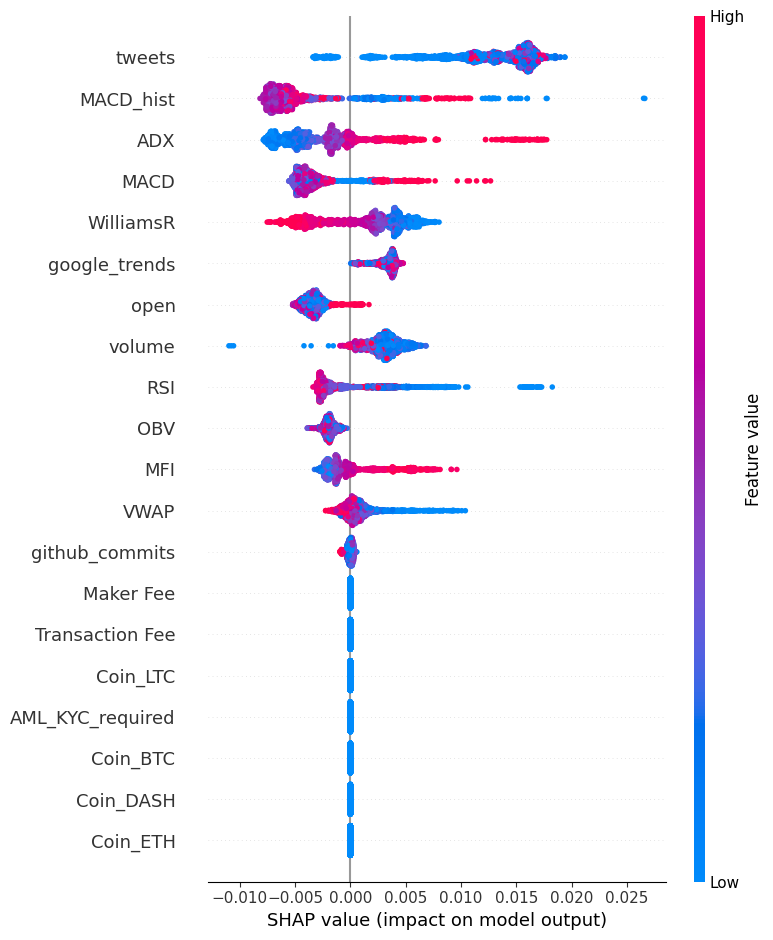

In [74]:
import shap

# Create an explainer object
explainer = shap.Explainer(opt.best_estimator_)

# Calculate the SHAP values for the test data
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)



# **GLOBAL FEATURE IMPORTANCE**
The shap.plots.bar function displays the global feature importance. Global feature importance refers to the average impact of each feature on the model’s predictions across all observations in the dataset.

In contrast, local feature importance refers to the impact of each feature on the model’s prediction for a single observation

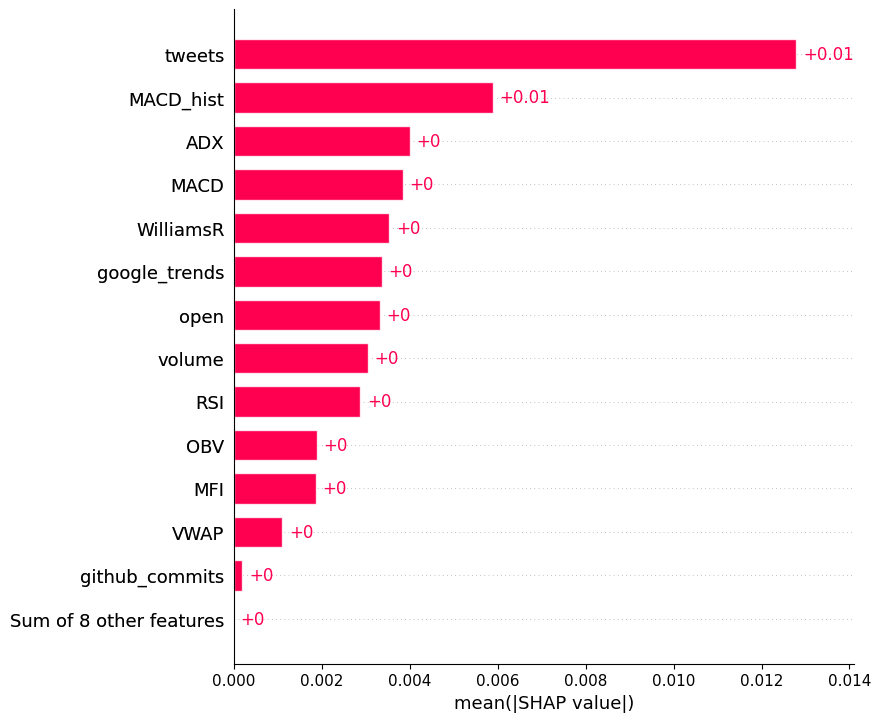

In [77]:
# Calculate the SHAP values for all observations in your dataset
shap_values = explainer(X_test_scaled)

# Set the feature names on the shap_values object
shap_values.feature_names = X_test.columns

# Plot the global feature importance
shap.plots.bar(shap_values,max_display=14)


In [87]:
print(X_test.columns)

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'Coin_BTC',
       'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP'],
      dtype='object')


In [89]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with the feature names and mean absolute SHAP values
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap_values
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 14 most important features as a table
feature_importance_df.head(22)


,feature,importance
4,tweets,0.015939
10,MACD_hist,0.005512
12,WilliamsR,0.005364
1,volume,0.004169
9,MACD,0.004169
3,google_trends,0.003751
7,MFI,0.002572
6,OBV,0.002408
0,open,0.001859
8,ADX,0.001526


In [92]:
# Calculate the sum of all importance scores
total_importance = feature_importance_df['importance'].sum()

# Calculate the percentage importance for each feature
feature_importance_df['importance_percentage'] = (feature_importance_df['importance'] / total_importance) * 100

# Round the percentage importance values to 2 decimal places
feature_importance_df['importance_percentage'] = feature_importance_df['importance_percentage'].round(2)

# Display the top 14 most important features as a table
feature_importance_df[['feature', 'importance_percentage']].head(14)
# Save the feature importance scores as a CSV file
feature_importance_df.to_csv('feature_importance_kraken.csv', index=False)


# **LOCAL FEATURE IMPORTANCE**

In [80]:
import matplotlib.pyplot as plt
print("Feature 100 Local importance")
print(X_test_scaled.shape)

# Choose an observation to explain
observation = X_test_scaled[100]

# Reshape the observation to have two dimensions
observation = observation.reshape(1, -1)

# Calculate the SHAP values for the observation
shap_values = explainer(observation)
shap.initjs()

# Plot the local feature importance
#shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns,matplotlib=True,show=False)
shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns)


Feature 100 Local importance
(2291, 21)


In [81]:
import matplotlib.pyplot as plt
print(" Local Feature importance of Feature 0")
print(X_test_scaled.shape)

# Choose an observation to explain
observation = X_test_scaled[0]

# Reshape the observation to have two dimensions
observation = observation.reshape(1, -1)

# Calculate the SHAP values for the observation
shap_values = explainer(observation)
shap.initjs()

# Plot the local feature importance
#shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns,matplotlib=True,show=False)
shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns)


 Local Feature importance of Feature 0
(2291, 21)


<Figure size 640x480 with 0 Axes>

In [130]:
X_test.columns


Index(['open', 'high', 'low', 'close', 'volume', 'github_commits',
       'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI', 'ADX', 'MACD',
       'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR', 'Maker Fee',
       'Transaction Fee', 'AML_KYC_required', 'Coin_BTC', 'Coin_DASH',
       'Coin_ETH', 'Coin_LTC', 'Coin_XRP'],
      dtype='object')

In [117]:
len(X_test.columns)

25

DimensionError: ignored